In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings('ignore')

### Custom Datasets

In [2]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

In [3]:
data = pd.read_csv("./data/data.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
# Dropping Turnover as it's not used for model building
data = data.drop("Turnover (Rs. Cr)", axis=1)
# Renaming 'Shared Traded' to 'Volume' as referred in the Thesis
data.rename(columns = {'Shares Traded': 'Volume'}, inplace = True)
# Getting log of 'Volume' to make it comparable to other independent variables
data['Log_Volume'] = np.log(data['Volume'])
data = data.drop("Volume", axis=1)
data.head()

,Date,Open,High,Low,Close,Log_Volume
0,2011-01-03,6177.45,6178.55,6147.20,6157.60,18.380157
1,2011-01-04,6172.75,6181.05,6124.40,6146.35,19.018021
2,2011-01-05,6141.35,6141.35,6062.35,6079.80,18.754393
3,2011-01-06,6107.00,6116.15,6022.30,6048.25,18.841619
4,2011-01-07,6030.90,6051.20,5883.60,5904.60,18.961895


In [4]:
len(data)

2621

We want to predict the next 5 business days on the basis of the past 100 business days.

We aim to include the first 2100 time-steps in our training set and the remaining 512 time-steps in our test set. In order to create a GluonTS freindly dataset, we divide the 2100 time-steps into 1994 individual series' of 105 time-steps which will be used for training. Similarly, test set shall be divided into individual series' of 105 time-steps for predictions.

In [5]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

# Test - Train Split (For Visualization)

In [6]:
nifty_data_metadata = {
    'num_series': 10,  # Determine this
    'num_steps': 5 + 5,
    'context_length': 5, # Number of datapoints to use, changing as per Thesis 3.2.2
    'prediction_length': 5, # Number of datapoints to predict
    'freq': '1B',
    'train_len': 2100
}

In [7]:
def extract_windows(arr, start_time_idx, max_time_idx, sub_window_size, time_lag=0):
    # Introduce time-lag by appending zeros
    assert(time_lag >= 0)
    arr = np.hstack(([0]*time_lag,arr))[:len(arr)]
    
    # Extract examples using sliding window
    examples = []
    start = start_time_idx
    end = max_time_idx - sub_window_size
    
    for i in range(end + 1):
        example = arr[start_time_idx+i:start_time_idx+sub_window_size+i]
        examples.append(np.expand_dims(example, 0))
    
    return np.vstack(examples)

In [8]:
def create_dataset(num_series, num_steps, period=5):
    # target - will be our Close price. Last index considered for forecast 2620 with a window size of 105
    target = extract_windows(np.array(data['Close']).flatten(), 0, data['Close'].shape[0], num_steps)
    
    start = extract_windows(data.index, 0, data.index.shape[0], num_steps).astype(int)
    start = np.vstack(data['Date'][datearr[0]] for datearr in start)
    start = [s.strftime("%Y-%m-%d %H:%M:%S") for s in start.flatten()]
    
    # create time features - open, high, low, close, volume (5 features) until 1B period earlier, append with zeros
    feat_dynamic_real = extract_windows(np.array(data['Open']), 0, data['Open'].shape[0], num_steps, time_lag=1)
    # Q: How to add other features to feat_dynamic_real?
    
    return target, start, feat_dynamic_real

In [9]:
data_out = create_dataset(
    nifty_data_metadata['num_series'],
    nifty_data_metadata['num_steps'],
    nifty_data_metadata['prediction_length']
)
target, start, feat_dynamic_real = data_out
nifty_data_metadata['num_series'] = len(start)
feat_dynamic_real

array([[    0.  ,  6177.45,  6172.75, ...,  5767.95,  5800.05,  5850.75],
       [ 6177.45,  6172.75,  6141.35, ...,  5800.05,  5850.75,  5752.1 ],
       [ 6172.75,  6141.35,  6107.  , ...,  5850.75,  5752.1 ,  5648.8 ],
       ...,
       [15794.  , 15808.7 , 15872.15, ..., 15856.8 , 15849.3 , 15860.5 ],
       [15808.7 , 15872.15, 15958.35, ..., 15849.3 , 15860.5 , 15761.55],
       [15872.15, 15958.35, 15754.5 , ..., 15860.5 , 15761.55, 15762.7 ]])

In [10]:
print(target.shape, len(start), feat_dynamic_real.shape)

(2612, 10) 2612 (2612, 10)


We can easily create the train and test datasets by simply filling in the correct fields. Remember that for the train dataset we need to cut the last window.

In [11]:
start[:4]

['2011-01-03 00:00:00',
 '2011-01-04 00:00:00',
 '2011-01-05 00:00:00',
 '2011-01-06 00:00:00']

In [12]:
target

array([[ 6157.6 ,  6146.35,  6079.8 , ...,  5863.25,  5751.9 ,  5654.55],
       [ 6146.35,  6079.8 ,  6048.25, ...,  5751.9 ,  5654.55,  5654.75],
       [ 6079.8 ,  6048.25,  5904.6 , ...,  5654.55,  5654.75,  5724.05],
       ...,
       [15853.95, 15924.2 , 15923.4 , ..., 15824.45, 15746.45, 15709.4 ],
       [15924.2 , 15923.4 , 15752.4 , ..., 15746.45, 15709.4 , 15778.45],
       [15923.4 , 15752.4 , 15632.1 , ..., 15709.4 , 15778.45, 15763.05]])

In [13]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
        }
        for (target, start, fdr) in zip(
            target[:, :-nifty_data_metadata['prediction_length']],
            start,
            feat_dynamic_real[:, :-nifty_data_metadata['prediction_length']]
        )
    ],
    freq=nifty_data_metadata['freq']
)
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
        }
        for (target, start, fdr) in zip(
            target,
            start,
            feat_dynamic_real)
    ],
    freq=nifty_data_metadata['freq']
)

In [14]:
# Update metadata
nifty_data_metadata['train_num_of_series'] = len(train_ds)
nifty_data_metadata['test_num_of_series'] = len(test_ds)

Examining both `train_ds` and `test_ds`.

In [15]:
nifty_data_metadata

{'num_series': 2612,
 'num_steps': 10,
 'context_length': 5,
 'prediction_length': 5,
 'freq': '1B',
 'train_len': 2100,
 'train_num_of_series': 2612,
 'test_num_of_series': 2612}

In [16]:
train_entry = next(iter(train_ds))
print(train_entry.keys())

test_entry = next(iter(test_ds))
print(test_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])
dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


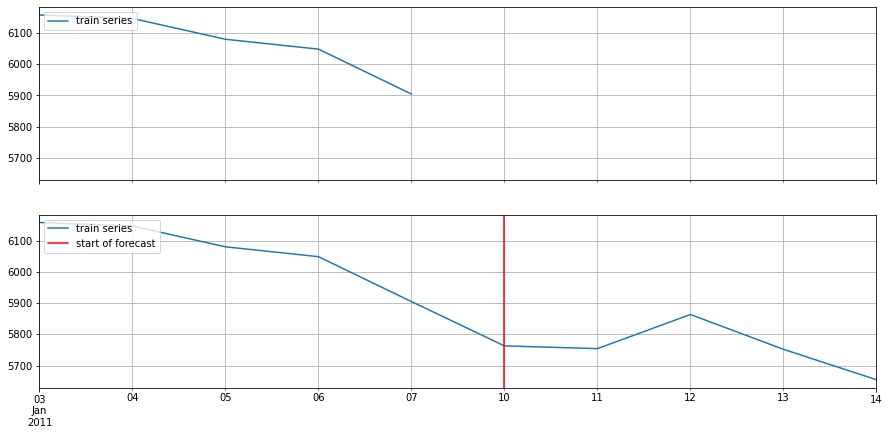

In [17]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(test_series.index[-nifty_data_metadata['prediction_length']], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["train series", "start of forecast"], loc="upper left")

plt.show()

Similarly, the 45th one should be starting from 45th time-step (i.e. early-Mar considering only Business Days) of the above example

In [18]:
td = iter(train_ds)
for _ in range(45):
    next(td)
train_entry = next(td)
print(train_entry.keys())

ts = iter(test_ds)
for _ in range(45):
    next(ts)
test_entry = next(ts)
print(test_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])
dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


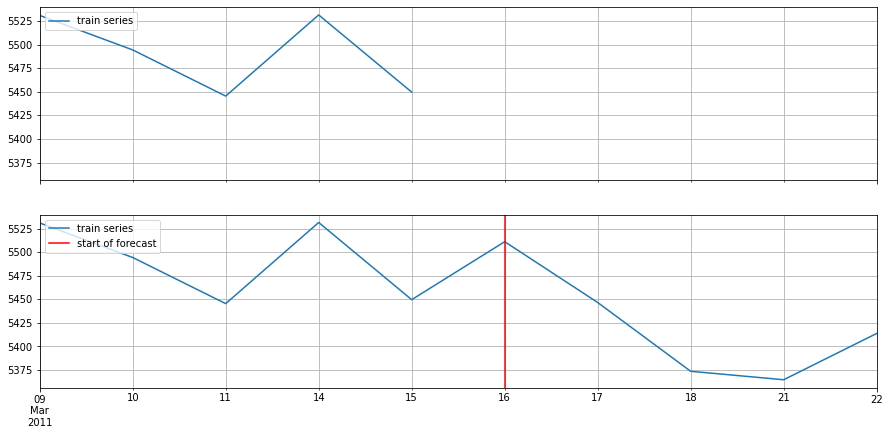

In [19]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(test_series.index[-nifty_data_metadata['prediction_length']], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["train series", "start of forecast"], loc="upper left")

plt.show()

This creates our train & test Dataset!

In [192]:
%%time
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
grouper_train = MultivariateGrouper(max_target_dim=nifty_data_metadata['train_num_of_series'])
grouper_test = MultivariateGrouper(max_target_dim=nifty_data_metadata['train_num_of_series'])
grouped_train_ds = grouper_train(train_ds)
grouped_test_ds = grouper_train(test_ds)

Wall time: 1min 52s


# Train/Test Split & Data Grouper (For Actual Forecasting)

In [20]:
data.head()

,Date,Open,High,Low,Close,Log_Volume
0,2011-01-03,6177.45,6178.55,6147.20,6157.60,18.380157
1,2011-01-04,6172.75,6181.05,6124.40,6146.35,19.018021
2,2011-01-05,6141.35,6141.35,6062.35,6079.80,18.754393
3,2011-01-06,6107.00,6116.15,6022.30,6048.25,18.841619
4,2011-01-07,6030.90,6051.20,5883.60,5904.60,18.961895


In [21]:
target = np.array(data['Close'])
# start = [s.strftime("%Y-%m-%d %H:%M:%S") for s in start.flatten()]
start = data['Date']
open_price = np.array(data['Open'])
high_price = np.array(data['High'])
low_price = np.array(data['Low'])
log_volume = np.array(data['Log_Volume'])


train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target[:nifty_data_metadata['train_len']],
            FieldName.START: start[0],
            FieldName.FEAT_DYNAMIC_REAL: [
                open_price[:nifty_data_metadata['train_len']],
                high_price[:nifty_data_metadata['train_len']],
                low_price[:nifty_data_metadata['train_len']],
                log_volume[:nifty_data_metadata['train_len']]
            ]
        }
    ],
    freq=nifty_data_metadata['freq']
)
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target[nifty_data_metadata['train_len']:],
            FieldName.START: start[nifty_data_metadata['train_len']],
            FieldName.FEAT_DYNAMIC_REAL: [
                open_price[nifty_data_metadata['train_len']:],
                high_price[nifty_data_metadata['train_len']:],
                low_price[nifty_data_metadata['train_len']:],
                log_volume[nifty_data_metadata['train_len']:]
            ]
        }
    ],
    freq=nifty_data_metadata['freq']
)

In [22]:
print("Train Len:", len(train_ds), "; Test Len:", len(test_ds))

Train Len: 1 ; Test Len: 1


In [23]:
it = iter(train_ds)
print(next(it))

{'target': array([ 6157.6 ,  6146.35,  6079.8 , ..., 11724.1 , 11699.65, 11796.45],
      dtype=float32), 'start': Timestamp('2011-01-03 00:00:00', freq='B'), 'feat_dynamic_real': array([[ 6177.45    ,  6172.75    ,  6141.35    , ..., 11827.6     ,
        11725.8     , 11681.      ],
       [ 6178.55    ,  6181.05    ,  6141.35    , ..., 11827.95    ,
        11754.      , 11814.4     ],
       [ 6147.2     ,  6124.4     ,  6062.35    , ..., 11705.1     ,
        11670.2     , 11651.      ],
       [   18.380157,    19.01802 ,    18.754393, ...,    19.964897,
           19.441767,    19.52088 ]], dtype=float32), 'source': SourceContext(source='list_data', row=0)}


In [24]:
it = iter(test_ds)
ts = next(it)
print(len(ts['target']))
print(ts)

521
{'target': array([11847.55, 11841.55, 11788.85, 11865.6 , 11910.3 , 11916.75,
       11946.75, 11811.15, 11558.6 , 11555.9 , 11498.9 , 11582.9 ,
       11552.5 , 11588.35, 11662.6 , 11687.5 , 11596.9 , 11419.25,
       11346.2 , 11331.05, 11271.3 , 11252.15, 11284.3 , 11189.2 ,
       11085.4 , 11118.  , 10980.  , 10997.35, 10862.6 , 10948.25,
       10855.5 , 11032.45, 11109.65, 10925.85, 11029.4 , 11047.8 ,
       11053.9 , 11017.  , 10918.7 , 10741.35, 10829.35, 11057.85,
       11105.35, 11046.1 , 10948.3 , 11023.25, 10797.9 , 10844.65,
       10847.9 , 10946.2 , 11003.05, 11035.7 , 10982.8 , 11075.9 ,
       11003.5 , 10817.6 , 10840.65, 10704.8 , 11274.2 , 11600.2 ,
       11588.2 , 11440.2 , 11571.2 , 11512.4 , 11474.45, 11359.9 ,
       11314.  , 11174.75, 11126.4 , 11313.3 , 11234.55, 11305.05,
       11341.15, 11428.3 , 11464.  , 11586.35, 11661.85, 11588.35,
       11604.1 , 11582.6 , 11583.9 , 11627.15, 11786.85, 11844.1 ,
       11877.45, 11890.6 , 11941.3 , 11917.2 , 

In [25]:
%%time
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
grouper_train = MultivariateGrouper(max_target_dim=1)
grouper_test = MultivariateGrouper(max_target_dim=1)
grouped_train_ds = grouper_train(train_ds)
grouped_test_ds = grouper_test(test_ds)

Wall time: 106 ms


In [26]:
it = iter(grouped_train_ds)
g_train_entry = next(it)
print(len(g_train_entry['target'][0]))
g_train_entry

2100


{'target': array([[ 6157.6 ,  6146.35,  6079.8 , ..., 11724.1 , 11699.65, 11796.45]],
       dtype=float32),
 'start': Timestamp('2011-01-03 00:00:00', freq='B'),
 'feat_static_cat': array([0]),
 'source': SourceContext(source='list_data', row=0)}

In [27]:
it = iter(grouped_test_ds)
g_test_entry = next(it)
print(len(g_test_entry['target'][0]))
g_test_entry

521


{'target': array([[11847.55, 11841.55, 11788.85, 11865.6 , 11910.3 , 11916.75,
         11946.75, 11811.15, 11558.6 , 11555.9 , 11498.9 , 11582.9 ,
         11552.5 , 11588.35, 11662.6 , 11687.5 , 11596.9 , 11419.25,
         11346.2 , 11331.05, 11271.3 , 11252.15, 11284.3 , 11189.2 ,
         11085.4 , 11118.  , 10980.  , 10997.35, 10862.6 , 10948.25,
         10855.5 , 11032.45, 11109.65, 10925.85, 11029.4 , 11047.8 ,
         11053.9 , 11017.  , 10918.7 , 10741.35, 10829.35, 11057.85,
         11105.35, 11046.1 , 10948.3 , 11023.25, 10797.9 , 10844.65,
         10847.9 , 10946.2 , 11003.05, 11035.7 , 10982.8 , 11075.9 ,
         11003.5 , 10817.6 , 10840.65, 10704.8 , 11274.2 , 11600.2 ,
         11588.2 , 11440.2 , 11571.2 , 11512.4 , 11474.45, 11359.9 ,
         11314.  , 11174.75, 11126.4 , 11313.3 , 11234.55, 11305.05,
         11341.15, 11428.3 , 11464.  , 11586.35, 11661.85, 11588.35,
         11604.1 , 11582.6 , 11583.9 , 11627.15, 11786.85, 11844.1 ,
         11877.45, 11890

The multivariate grouper is dropping the `feat_dynamic_real` field. But this grouping is required for advanced deep learning models.

# Basic Requirements

In [28]:
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

In [29]:
from pathlib import Path
from gluonts.evaluation.backtest import backtest_metrics
from gluonts.model.predictor import Predictor

In [30]:
nifty_data_metadata['num_series'] = 1
nifty_data_metadata['test_len'] = len(next(iter(test_ds))['target'])
nifty_data_metadata['train_num_of_series'] = 1
nifty_data_metadata['test_num_of_series'] = 1
nifty_data_metadata

{'num_series': 1,
 'num_steps': 10,
 'context_length': 5,
 'prediction_length': 5,
 'freq': '1B',
 'train_len': 2100,
 'train_num_of_series': 1,
 'test_num_of_series': 1,
 'test_len': 521}

# Custom Evaluator to add POCID & Thiel's U

In [31]:
import json
from typing import Dict, Tuple, Union
import numpy as np
import pandas as pd
from gluonts.evaluation import Evaluator
from gluonts.model.forecast import Forecast

from scipy.ndimage.interpolation import shift

class MyEvaluator(Evaluator):
    
    @staticmethod
    def pocid(target, forecast):
        '''
        calculates the accuracy of estimation of direction by the model.
        If the predicted direction of change is the same as actual direction of change, Dt will be 1.
        Otherwise, Dt will be 0.
        
        Two ways to write:
        1. Determine POCID for only for first day of forecast
        2. Determine POCID for (last-first), i.e. pred vs actual of the direction ts will go on last day
        3. Aggregate for each day in prediction_length
        Picking 3 for now
        
        Leaving out first forecast as the previous value is not known while evaluating.
        '''
        target_diff = target - shift(target, 1, cval=np.mean(target))
        target_diff = np.delete(target_diff, 0)
        forecast_diff = forecast - shift(forecast, 1, cval=np.mean(forecast))
        forecast_diff = np.delete(forecast_diff, 0)
        prod = np.multiply(target_diff, forecast_diff)
        prod[prod>0] = 1
        prod[prod<=0] = 0
        pocid = (np.sum(prod)/len(prod))*100
#         print("POCID:", pocid)
        return pocid
    
    @staticmethod
    def theilU(target, forecast):
        '''
        𝑇𝑈= Σ(𝑦𝑡− 𝑦̂𝑡)2 / Σ(𝑦𝑡− 𝑦𝑡−1)2
        
        Leaving out first forecast as the previous value is not known while evaluating.
        '''
        target_lag = shift(target, 1, cval=np.mean(target))
        nom = np.sum(np.square(target-forecast))
        denom = np.sum(np.square(target-target_lag))
        tu = nom/denom
#         print("Theil's U:", tu)
        return tu

    def get_metrics_per_ts(
        self, time_series: Union[pd.Series, pd.DataFrame], forecast: Forecast
    ) -> Dict[str, Union[float, str, None]]:
        metrics = super().get_metrics_per_ts(time_series, forecast)

        pred_target = np.array(self.extract_pred_target(time_series, forecast))
        pred_target = np.ma.masked_invalid(pred_target)
        median_fcst = forecast.quantile(0.5)

        metrics["POCID"] = self.pocid(
            pred_target, median_fcst
        )
        metrics["Theil's U"] = self.theilU(
            pred_target, median_fcst
        )
        return metrics

    def get_aggregate_metrics(
        self, metric_per_ts: pd.DataFrame
    ) -> Tuple[Dict[str, float], pd.DataFrame]:
        totals, metric_per_ts = super().get_aggregate_metrics(metric_per_ts)

        agg_funs = {
            "POCID": "mean",
            "Theil's U": "mean",
        }
        assert (
            set(metric_per_ts.columns) >= agg_funs.keys()
        ), "Some of the requested item metrics are missing."
        my_totals = {
            key: metric_per_ts[key].agg(agg) for key, agg in agg_funs.items()
        }

        totals.update(my_totals)
        return totals, metric_per_ts

### Training an existing model (Estimator)

In [32]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [33]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=nifty_data_metadata['prediction_length'],
    context_length=nifty_data_metadata['context_length'],
    freq=nifty_data_metadata['freq'],
    trainer=Trainer(
        ctx="cpu",
        epochs=50,
        learning_rate=1e-3,
        num_batches_per_epoch=50
    )
)

In [34]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:00<00:00, 147.51it/s, epoch=50/50, avg_epoch_loss=6.4]


### Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the dataset.test and evaluate our model’s performance.

GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

Removes the final window of length prediction_length of the dataset.test that we want to predict

The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed

The module outputs the forecast sample paths and the dataset.test (as python generator objects)

In [35]:
from gluonts.evaluation import make_evaluation_predictions

In [36]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [37]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let’s start with the list containing the time series, i.e., tss. We expect the first entry of tss to contain the (target of the) first time series of dataset.test.

In [38]:
# first entry of the time series list
ts_entry = tss[0]

In [39]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([11847.55, 11841.55, 11788.85, 11865.6 , 11910.3 ], dtype=float32)

In [40]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [41]:
# first 5 values
dataset_test_entry['target'][:5]

array([11847.55, 11841.55, 11788.85, 11865.6 , 11910.3 ], dtype=float32)

The entries in the forecast list are a bit more complex. They are objects that contain all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [42]:
len(forecasts)

1

In [43]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [44]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 5)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B


1B == 1 Business Day; https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
<br/><br/>We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [45]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [15815.8   15827.457 15786.902 15816.119 15866.224]
0.5-quantile (median) of the future window:
 [15811.04  15864.418 15747.344 15788.492 15866.252]


Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.



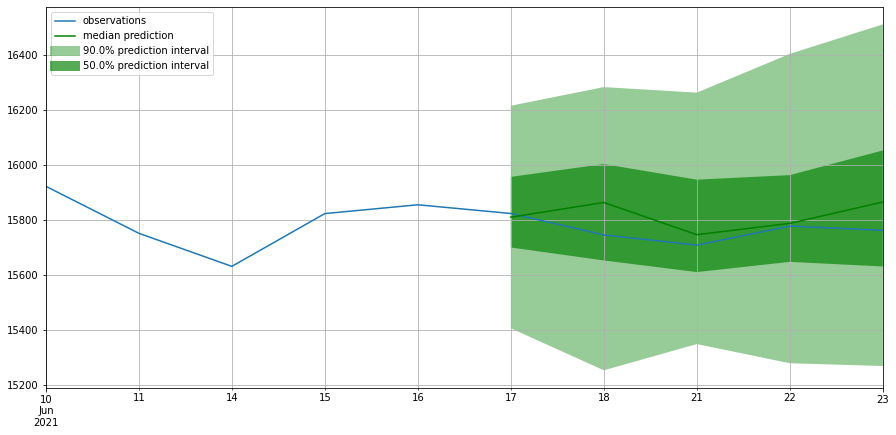

In [46]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).



In [47]:
evaluator = MyEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 61.93it/s]


In [48]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4941.45546875,
    "abs_error": 282.5654296875,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 0.22159945768079317,
    "MAPE": 0.0035875994712114335,
    "sMAPE": 0.0035771839320659637,
    "MSIS": 5.111306711300601,
    "QuantileLoss[0.1]": 304.142578125,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 282.5654296875,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 438.68710937499986,
    "Coverage[0.9]": 1.0,
    "RMSE": 70.29548683059248,
    "NRMSE": 0.004459140086724424,
    "ND": 0.003584864097117806,
    "wQuantileLoss[0.1]": 0.003858610056902487,
    "wQuantileLoss[0.5]": 0.003584864097117806,
    "wQuantileLoss[0.9]": 0.00556555580775067,
    "mean_absolute_QuantileLoss": 341.79837239583327,
    "mean_wQuantileLoss": 0.004336343320590321,
    "MAE_Coverage": 0.16666666666666666,
    "OWA": NaN,
    "POCID": 50.0,
    "Theil's U": 1.635540246963501
}


In [49]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9],POCID,Theil's U
0,NaN,4941.455469,282.56543,78821.796875,15764.359375,255.023575,0.221599,0.003588,0.003577,5.111307,304.142578,0.0,282.56543,0.8,438.687109,1.0,50.0,1.63554


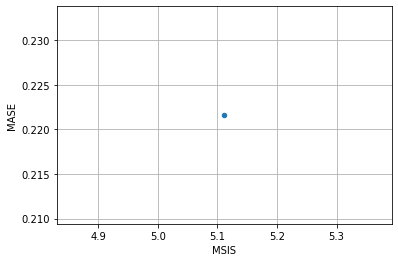

In [50]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Deep Factor - RNN (DFRNN)

In [51]:
nifty_data_metadata

{'num_series': 1,
 'num_steps': 10,
 'context_length': 5,
 'prediction_length': 5,
 'freq': '1B',
 'train_len': 2100,
 'train_num_of_series': 1,
 'test_num_of_series': 1,
 'test_len': 521}

In [54]:
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.mx.distribution import StudentTOutput
# With default values
DeepFactorBasic = DeepFactorEstimator(freq=nifty_data_metadata['freq'],
                                      context_length=nifty_data_metadata['context_length'],
                                      prediction_length=nifty_data_metadata['prediction_length'],
                                      num_layers_global=1, num_layers_local=5,
                                      num_hidden_global=50, num_hidden_local=5,
                                      cell_type='lstm', cardinality=[nifty_data_metadata['train_num_of_series']],
                                      trainer=Trainer(ctx=ctx, epochs=50, learning_rate=1e-3,
                                                    hybridize=True, num_batches_per_epoch=100))

In [55]:
try:
    deepFactorPredictor = Predictor.deserialize(Path("./models/DeepFactorBasic/"))
    print("Loaded from memory")
except:
    deepFactorPredictor = DeepFactorBasic.train(train_ds)
    deepFactorPredictor.serialize(Path("./models/DeepFactorBasic/"))

100%|██████████| 100/100 [00:00<00:00, 102.48it/s, epoch=50/50, avg_epoch_loss=53.6]


In [59]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepFactorPredictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [60]:
deepFactor_forecasts = list(forecast_it)
deepFactor_tss = list(ts_it)

In [61]:
# first entry of the time series list
ts_entry = deepFactor_tss[0]
# first 5 values of the time series (convert from pandas to numpy)
print(np.array(ts_entry[:5]).reshape(-1,))
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))
# first 5 values
print(dataset_test_entry['target'][:5])

[11847.55 11841.55 11788.85 11865.6  11910.3 ]
[11847.55 11841.55 11788.85 11865.6  11910.3 ]


In [62]:
print(len(deepFactor_forecasts))
# first entry of the forecast list
forecast_entry = deepFactor_forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

1
Number of sample paths: 100
Dimension of samples: (100, 5)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B


In [63]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 9943.468  8696.597 23411.627 14537.724 14287.767]
0.5-quantile (median) of the future window:
 [ 9942.634  8692.923 23411.738 14541.067 14291.093]


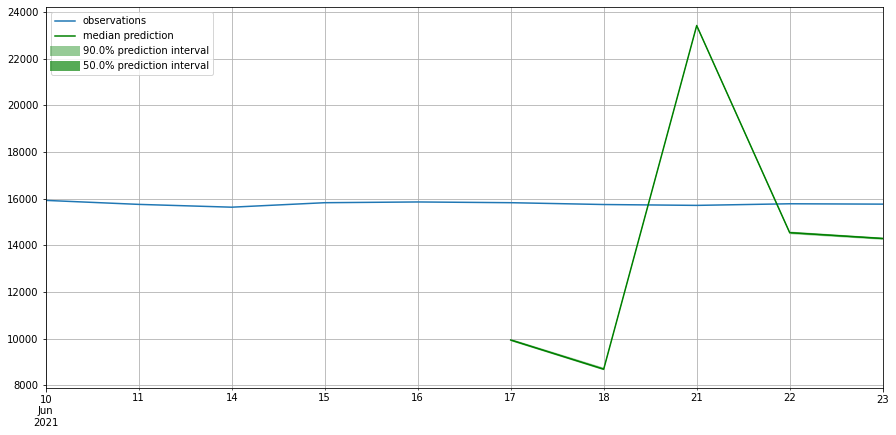

In [64]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)

In [65]:
from gluonts.evaluation import Evaluator
evaluator = MyEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(deepFactor_tss), iter(deepFactor_forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 125.05it/s]


In [66]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 29465312.0,
    "abs_error": 23347.021484375,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 18.309696643078762,
    "MAPE": 0.29634785652160645,
    "sMAPE": 0.32142176628112795,
    "MSIS": 723.4249811187643,
    "QuantileLoss[0.1]": 16950.514843750003,
    "Coverage[0.1]": 0.2,
    "QuantileLoss[0.5]": 23347.021484375,
    "Coverage[0.5]": 0.2,
    "QuantileLoss[0.9]": 29445.046875000004,
    "Coverage[0.9]": 0.2,
    "RMSE": 5428.196017094446,
    "NRMSE": 0.3443334351856239,
    "ND": 0.2962000666059416,
    "wQuantileLoss[0.1]": 0.2150485717882209,
    "wQuantileLoss[0.5]": 0.2962000666059416,
    "wQuantileLoss[0.9]": 0.37356477576495245,
    "mean_absolute_QuantileLoss": 23247.527734375002,
    "mean_wQuantileLoss": 0.29493780471970504,
    "MAE_Coverage": 0.3666666666666667,
    "OWA": NaN,
    "POCID": 50.0,
    "Theil's U": 9169.109375
}


In [67]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9],POCID,Theil's U
0,NaN,29465312.0,23347.021484,78821.796875,15764.359375,255.023575,18.309697,0.296348,0.321422,723.424981,16950.514844,0.2,23347.021484,0.2,29445.046875,0.2,50.0,9169.109375


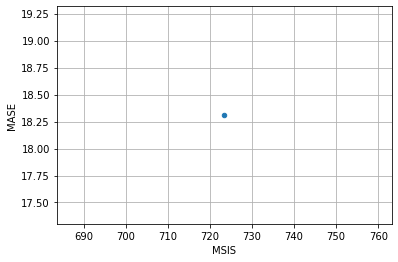

In [68]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# DeepAR

In [69]:
from gluonts.model.deepar import DeepAREstimator
# Default Params
DeepARBasic = DeepAREstimator(freq=nifty_data_metadata['freq'],
                              prediction_length=nifty_data_metadata['prediction_length'],
                              context_length=nifty_data_metadata['context_length'],
                              num_layers=3, num_cells=40, cell_type="lstm", scaling=True,
                              trainer=Trainer(ctx=ctx, epochs=50, learning_rate=1e-3,
                                             hybridize=True, num_batches_per_epoch=100))

In [70]:
try:
    deepARPredictor = Predictor.deserialize(Path("./models/DeepARBasic/"))
    print("Loaded from memory")
except:
    deepARPredictor = DeepARBasic.train(train_ds)
    deepARPredictor.serialize(Path("./models/DeepARBasic/"))

100%|██████████| 100/100 [00:02<00:00, 43.14it/s, epoch=50/50, avg_epoch_loss=5.86]


In [71]:
# Eval on Test Data
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepARPredictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
deepAR_forecasts = list(forecast_it)
deepAR_tss = list(ts_it)

In [89]:
print(len(deepAR_forecasts))
# first entry of the forecast list
forecast_entry = deepAR_forecasts[0]
ts_entry = deepAR_tss[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

1
Number of sample paths: 100
Dimension of samples: (100, 5)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [15836.247 15818.23  15765.775 15731.463 15643.56 ]
0.5-quantile (median) of the future window:
 [15847.603 15834.945 15777.439 15730.363 15651.441]


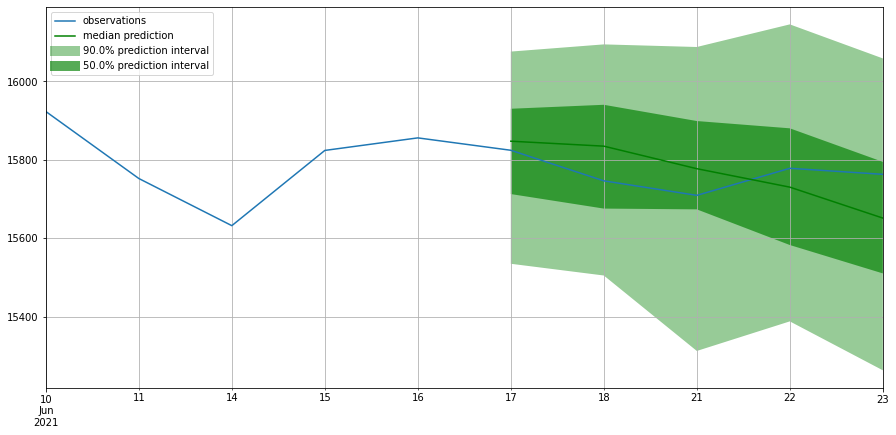

In [90]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)

In [74]:
from gluonts.evaluation import Evaluator
evaluator = MyEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(deepAR_tss), iter(deepAR_forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 122.45it/s]


In [75]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4991.0875,
    "abs_error": 339.3818359375,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 0.2661572255092778,
    "MAPE": 0.004308439046144486,
    "sMAPE": 0.004309165477752686,
    "MSIS": 3.5509071610930603,
    "QuantileLoss[0.1]": 256.65,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 339.3818359375,
    "Coverage[0.5]": 0.6,
    "QuantileLoss[0.9]": 248.19765624999994,
    "Coverage[0.9]": 1.0,
    "RMSE": 70.64762911803905,
    "NRMSE": 0.0044814779616148565,
    "ND": 0.004305685094640898,
    "wQuantileLoss[0.1]": 0.0032560790311214277,
    "wQuantileLoss[0.5]": 0.004305685094640898,
    "wQuantileLoss[0.9]": 0.0031488454474541557,
    "mean_absolute_QuantileLoss": 281.40983072916663,
    "mean_wQuantileLoss": 0.0035702031910721604,
    "MAE_Coverage": 0.09999999999999998,
    "OWA": NaN,
    "POCID": 75.0,
    "Theil's U": 1.7275017499923706
}


In [76]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9],POCID,Theil's U
0,NaN,4991.0875,339.381836,78821.796875,15764.359375,255.023575,0.266157,0.004308,0.004309,3.550907,256.65,0.0,339.381836,0.6,248.197656,1.0,75.0,1.727502


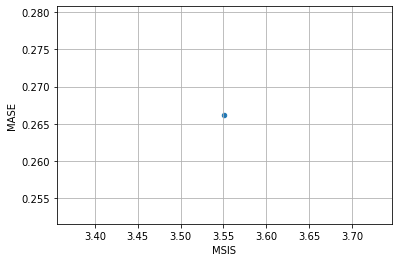

In [77]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Deep State Space Model

In [78]:
from gluonts.model.deepstate import DeepStateEstimator
DeepStateBasic = DeepStateEstimator(freq=nifty_data_metadata['freq'],
                                   prediction_length=nifty_data_metadata['prediction_length'],
                                   past_length=nifty_data_metadata['context_length'], add_trend=True,
                                   use_feat_static_cat=False, cardinality=[],
                                   trainer=Trainer(ctx=ctx, epochs=50, learning_rate=1e-3,
                                               hybridize=True, num_batches_per_epoch=100))

In [79]:
try:
    deepStatePredictor = Predictor.deserialize(Path("./models/DeepStateBasic/"))
    print("Loaded from memory")
except:
    deepStatePredictor = DeepStateBasic.train(train_ds)
    deepStatePredictor.serialize(Path("./models/DeepStateBasic/"))

100%|██████████| 100/100 [00:01<00:00, 61.91it/s, epoch=50/50, avg_epoch_loss=5.32]


In [80]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepStatePredictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
deepState_forecasts = list(forecast_it)
deepState_tss = list(ts_it)

In [91]:
print(len(deepState_forecasts))
# first entry of the forecast list
forecast_entry = deepState_forecasts[0]
ts_entry = deepState_tss[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

1
Number of sample paths: 100
Dimension of samples: (100, 5)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [16113.762 11150.838 10772.58  10956.968 10989.593]
0.5-quantile (median) of the future window:
 [16105.28   11139.886  10769.1045 10950.82   10983.49  ]


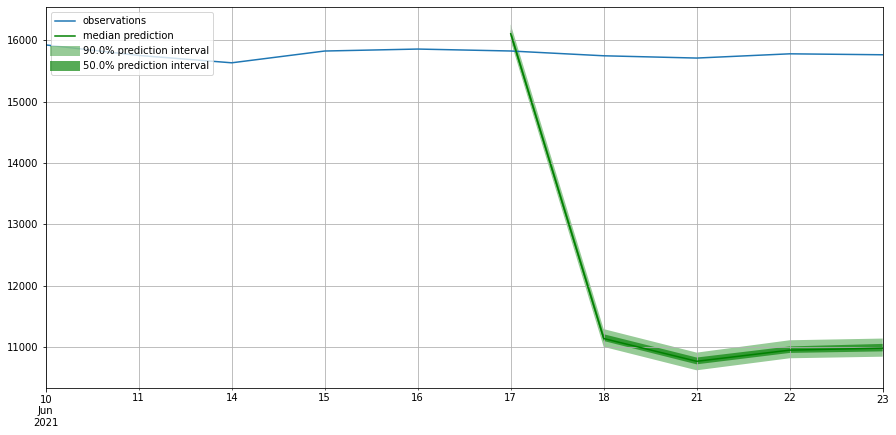

In [92]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)

In [83]:
from gluonts.evaluation import MultivariateEvaluator
evaluator = MyEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(deepState_tss), iter(deepState_forecasts), num_series=len(grouped_test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [84]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 18321625.6,
    "abs_error": 19434.87890625,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 15.24163316963401,
    "MAPE": 0.24678988456726075,
    "sMAPE": 0.29040720462799074,
    "MSIS": 582.1790198927112,
    "QuantileLoss[0.1]": 4236.385351562501,
    "Coverage[0.1]": 0.2,
    "QuantileLoss[0.5]": 19434.8798828125,
    "Coverage[0.5]": 0.2,
    "QuantileLoss[0.9]": 33741.5013671875,
    "Coverage[0.9]": 0.2,
    "RMSE": 4280.37680584315,
    "NRMSE": 0.27152240722393134,
    "ND": 0.246567316107636,
    "wQuantileLoss[0.1]": 0.053746368638116646,
    "wQuantileLoss[0.5]": 0.24656732849713406,
    "wQuantileLoss[0.9]": 0.4280732323407528,
    "mean_absolute_QuantileLoss": 19137.5888671875,
    "mean_wQuantileLoss": 0.24279564315866783,
    "MAE_Coverage": 0.3666666666666667,
    "OWA": NaN,
    "POCID": 75.0,
    "Theil's U": 5715.0546875
}


In [85]:
print(agg_metrics["MSE"], agg_metrics["RMSE"], agg_metrics["MASE"], agg_metrics["MAPE"])

18321625.6 4280.37680584315 15.24163316963401 0.24678988456726075


# LSTNet

In [86]:
nifty_data_metadata

{'num_series': 1,
 'num_steps': 10,
 'context_length': 5,
 'prediction_length': 5,
 'freq': '1B',
 'train_len': 2100,
 'train_num_of_series': 1,
 'test_num_of_series': 1,
 'test_len': 521}

In [93]:
from gluonts.model.lstnet import LSTNetEstimator
LSTNetBasic = LSTNetEstimator(
        skip_size=5, ar_window=5, num_series=nifty_data_metadata['num_series'],
        rnn_num_layers=1, skip_rnn_num_layers=20,
        channels=5*5*5, kernel_size=1, dropout_rate=0.2, output_activation='sigmoid',
        freq=nifty_data_metadata['freq'], prediction_length=nifty_data_metadata['prediction_length'],
        context_length=nifty_data_metadata['context_length'],
        trainer=Trainer(ctx=ctx, epochs=50, hybridize=True,
                        learning_rate=1e-3, num_batches_per_epoch=100)
)

In [88]:
try:
    LSTNetBasicPredictor = Predictor.deserialize(Path("./models/LSTNetBasic/"))
    print("Loaded from memory")
except:
    LSTNetBasicPredictor = LSTNetBasic.train(grouped_train_ds)
    LSTNetBasicPredictor.serialize(Path("./models/LSTNetBasic/"))

100%|██████████| 100/100 [00:02<00:00, 48.61it/s, epoch=50/50, avg_epoch_loss=116]


No further epochs needed as the avg_epoch_loss stagnates!

In [94]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=grouped_test_ds,  # test dataset
    predictor=LSTNetBasicPredictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [95]:
len(next(iter(grouped_test_ds))['target'][0])

521

In [96]:
LSTNet_forecasts = list(forecast_it)
LSTNet_tss = list(ts_it)

In [97]:
print(len(LSTNet_forecasts))
# first entry of the forecast list
forecast_entry = LSTNet_forecasts[0]
ts_entry = LSTNet_tss[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

1
Number of sample paths: 100
Dimension of samples: (100, 5, 1)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [[15797.593]
 [15797.409]
 [15797.593]
 [15797.51 ]
 [15797.374]]
0.5-quantile (median) of the future window:
 [[15797.585]
 [15797.421]
 [15797.585]
 [15797.524]
 [15797.374]]


In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry[0], forecast_entry)

In [99]:
agg_metrics, _ = backtest_metrics(
        test_dataset=grouped_test_ds,
        predictor=LSTNetBasicPredictor,
        evaluator=MyEvaluator(
            quantiles=(0.1, 0.5, 0.9)
        ),
    )

Running evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [100]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 2528.45296875,
    "abs_error": 1097.9658203125,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 0.17221401117778745,
    "MAPE": 0.0027891135215759276,
    "sMAPE": 0.002784595787525177,
    "MSIS": 6.888560447111497,
    "QuantileLoss[0.1]": 1760.7197265625,
    "Coverage[0.1]": 0.8,
    "QuantileLoss[0.5]": 1097.9658203125,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 435.2119140625,
    "Coverage[0.9]": 0.8,
    "RMSE": 50.28372469050001,
    "NRMSE": 0.0031897093623888544,
    "ND": 0.013929723297905977,
    "wQuantileLoss[0.1]": 0.02233798005588159,
    "wQuantileLoss[0.5]": 0.013929723297905977,
    "wQuantileLoss[0.9]": 0.005521466539930361,
    "mean_absolute_QuantileLoss": 1097.9658203125,
    "mean_wQuantileLoss": 0.013929723297905976,
    "MAE_Coverage": 0.3666666666666667,
    "OWA": NaN,
    "POCID": 75.0,
    "Theil's U": 3.933072805404663
}


In [101]:
print(agg_metrics["MSE"], agg_metrics["RMSE"], agg_metrics["MASE"], agg_metrics["MAPE"])

2528.45296875 50.28372469050001 0.17221401117778745 0.0027891135215759276


# Ensemble

In [115]:
print(deepAR_forecasts)
print(deepAR_tss)
print(LSTNet_forecasts)
print(LSTNet_tss)

[gluonts.model.forecast.SampleForecast(freq="1B", info=None, item_id=None, samples=numpy.array([[15981.2099609375, 15916.7587890625, 15847.53515625, 15769.7880859375, 15448.828125], [15896.318359375, 15542.865234375, 15716.1201171875, 15769.0859375, 15543.75390625], [15965.435546875, 15875.845703125, 15821.7119140625, 15811.6181640625, 15383.1552734375], [16030.9287109375, 15993.7578125, 15773.7021484375, 16201.28515625, 16317.1669921875], [15597.1279296875, 15890.634765625, 15716.54296875, 16166.2421875, 15337.24609375], [15991.744140625, 15913.052734375, 15988.90625, 15598.609375, 15626.193359375], [15576.3828125, 15615.55859375, 15673.67578125, 15679.4990234375, 15546.27734375], [15692.3662109375, 15731.1904296875, 15675.7041015625, 15859.4443359375, 15726.81640625], [15825.2451171875, 15910.9130859375, 15558.0458984375, 16002.3173828125, 15577.203125], [16117.6474609375, 15839.373046875, 15818.9853515625, 15387.8740234375, 15741.6787109375], [15932.287109375, 15602.8671875, 15774.4

In [148]:
ensemble_forecasts = LSTNet_forecasts
ensemble_tss = deepAR_tss    # Picking from DeepAR as we'll ungroup LSTNet_forecasts
print(len(ensemble_forecasts))
ensemble_forecasts[0].samples = (np.divide(np.add(deepAR_forecasts[0].samples,
                     LSTNet_forecasts[0].samples.reshape(100,5)), 2))

1


In [149]:
print(len(ensemble_forecasts))
# first entry of the forecast list
forecast_entry = ensemble_forecasts[0]
ts_entry = ensemble_tss[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

1
Number of sample paths: 100
Dimension of samples: (100, 5)
Start date of the forecast window: 2021-06-17 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [15831.42  15815.622 15769.746 15739.723 15662.791]
0.5-quantile (median) of the future window:
 [[15797.585]
 [15797.421]
 [15797.585]
 [15797.524]
 [15797.374]]


In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = nifty_data_metadata['num_steps']
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(ts_entry, forecast_entry)

In [151]:
from gluonts.evaluation import MultivariateEvaluator
evaluator = MyEvaluator(quantiles=[0.1, 0.5, 0.9])
# Don't need the grouped test ds as we removed the grouping while averaging forecasts
agg_metrics, item_metrics = evaluator(iter(ensemble_tss), iter(ensemble_forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 62.52it/s]


In [152]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4005.315625,
    "abs_error": 1097.9658203125,
    "abs_target_sum": 78821.796875,
    "abs_target_mean": 15764.359375,
    "seasonal_error": 255.02357509784736,
    "MASE": 0.17221401117778745,
    "MAPE": 0.0027891135215759276,
    "sMAPE": 0.002784595787525177,
    "MSIS": 6.888560447111497,
    "QuantileLoss[0.1]": 1760.7197265625,
    "Coverage[0.1]": 0.8,
    "QuantileLoss[0.5]": 1097.9658203125,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 435.2119140625,
    "Coverage[0.9]": 0.8,
    "RMSE": 63.2875629567137,
    "NRMSE": 0.004014597831173441,
    "ND": 0.013929723297905977,
    "wQuantileLoss[0.1]": 0.02233798005588159,
    "wQuantileLoss[0.5]": 0.013929723297905977,
    "wQuantileLoss[0.9]": 0.005521466539930361,
    "mean_absolute_QuantileLoss": 1097.9658203125,
    "mean_wQuantileLoss": 0.013929723297905976,
    "MAE_Coverage": 0.3666666666666667,
    "OWA": NaN,
    "POCID": 75.0,
    "Theil's U": 3.933072805404663
}


In [153]:
print(agg_metrics["MSE"], agg_metrics["RMSE"], agg_metrics["MASE"], agg_metrics["MAPE"])

4005.315625 63.2875629567137 0.17221401117778745 0.0027891135215759276
